-1720287.5 -1652400.0 -2423075.0 -2342800.0


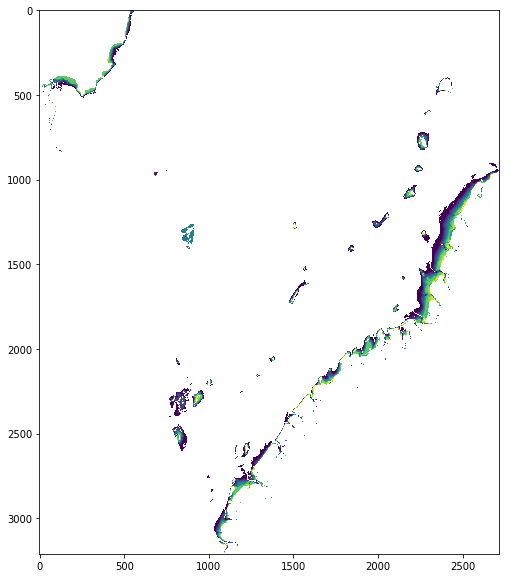

In [76]:
import datacube
import numpy as np
import rasterio
import rasterio.features
from osgeo import gdal
from shapely.geometry import Point
from shapely.geometry import shape
from scipy.interpolate import griddata, LinearNDInterpolator
from matplotlib import pyplot as plt


def write_geotiff(fname, data, geo_transform, projection, nodata_val):
    
    """
    Create a single band GeoTIFF file with data from array.
    
    :attr fname: output file path
    :attr data: input array
    :attr geo_transform: geotransform for output raster
    :attr projection: projection for output raster
    :attr nodata_val: value to convert to nodata in output raster
    """
    
    # Set up driver
    driver = gdal.GetDriverByName('GTiff')
    
    # Create raster of given size and projection
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Float32)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    
    # Write data to array and set nodata values
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata_val)
#     band.ComputeStatistics(0)
    
    # Close file
    dataset = None  

    
# Extract tuples of x, y, z coordinates for each point feature
data_source = gdal.OpenEx("/g/data/r78/rt1527/item_dem/test_gis/contours_simple.shp", gdal.OF_VECTOR)
input_data = data_source.GetLayer(0)
point_coords = [feature.geometry().Centroid().GetPoint()[0:2] for feature in input_data]
input_data.ResetReading()
point_values = [feature.GetField("elev") for feature in input_data]
point_values

# Extract coordinates from points and reverse xy columns
points = np.array(point_coords)[:,[1, 0]]
values = np.array(point_values)
miny, minx  = np.amin(points, axis = 0)
maxy, maxx = np.amax(points, axis = 0)
print(minx, maxx, miny, maxy)

# Import datacube and create interpolation grid
dc = datacube.Datacube(app = 'Interpolation')
matching_data = dc.load(product = "item_v2", 
                        x = (minx, maxx), 
                        y = (miny, maxy), 
                        crs = 'EPSG:3577')
bands, xcols, yrows = matching_data.relative.shape

# Create interpolation grid
grid_y, grid_x = np.mgrid[maxy:miny:1j * xcols,
                          minx:maxx:1j * yrows]

# Interpolate between points onto grid
grid_z0 = griddata(points, values, (grid_y, grid_x), method = 'linear')

# Mask out highest and lowest tide from ITEM v2
mask = ((matching_data.relative == 0) | (matching_data.relative == 9)).isel(time = 0).values
grid_z0[mask] = np.nan

# Plot
plt.figure(figsize = (10, 10))
plt.imshow(grid_z0)
plt.show()

# Export to tif
proj = matching_data.geobox.crs.wkt
geo_transform = matching_data.geobox.transform.to_gdal() 
write_geotiff(fname = "test2.tif", 
              data = grid_z0, 
              geo_transform = geo_transform, 
              projection = proj, 
              nodata_val = np.nan)
